In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import autograd as ag
import numpy as np 
import os
import copy
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import corner
import pyccl as ccl

from tqdm import tqdm, trange

from scipy.interpolate import interp1d, UnivariateSpline
from scipy.optimize import curve_fit

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.decomposition import PCA


from numpy.polynomial import Chebyshev

import src.datamaker as datamaker
import src.training as training
import src.models as models

from importlib import reload
reload(datamaker)
reload(training)
reload(models)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

In [2]:
# Load in training data
if os.path.isfile('data/Cgg_samples_120tasks_2048samples.npz'):
    with np.load('data/Cgg_samples_120tasks_2048samples.npz') as data:
        X_train = data['X_train']
        Y_train = data['Y_train']
        survey_midpoints = data['survey_midpoints']
        survey_pz = data['survey_pz']
        qrd_pz = data['qrd_pz']

print(X_train.shape)
print(Y_train.shape)

(120, 2048, 6)
(120, 2048, 30)


In [3]:
# Check if survey mid points is just tiled
tiled = True
for i in range(survey_midpoints.shape[0] - 1):
    if all(survey_midpoints[i]) != all(survey_midpoints[i+1]):
        tiled = False
        break
    
# compress the survey midpoints along the first axis
if tiled:
    survey_midpoints = survey_midpoints[0]

print(survey_midpoints.shape)

(49,)


Text(0.5, 0, '$\\ell$')

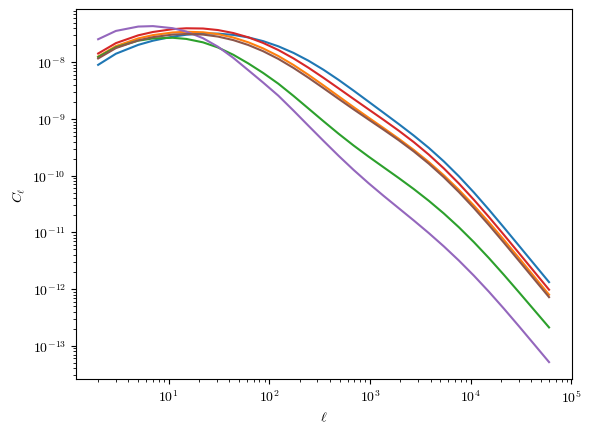

In [4]:
ell_bins = np.unique(np.geomspace(2, 60000, 31).astype(int))
for i in range(2**10):
    if i % 200 == 0:
        plt.loglog(ell_bins,Y_train[19,i])
plt.ylabel(r'$C_{\ell}$')
plt.xlabel(r'$\ell$')

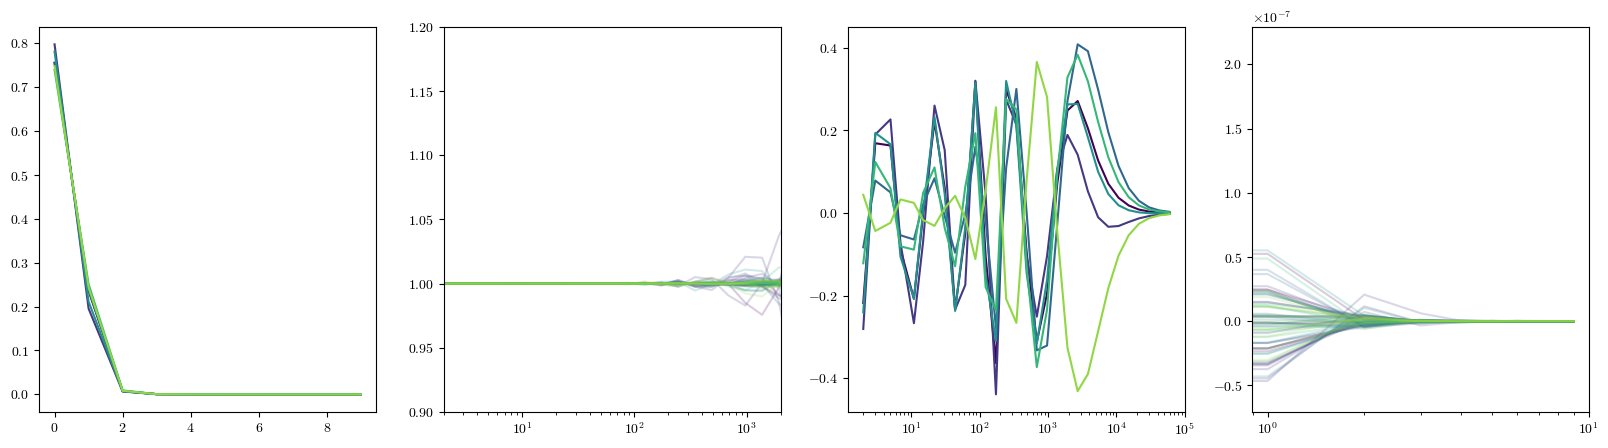

In [43]:
# Attempt to PCA the data

norm = matplotlib.colors.Normalize(vmin=0, vmax=len(Y_train))
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.viridis)

fig, ax = plt.subplots(1,4,figsize=(20,5))

# Need to run PCA individually for each survey
for i in range(Y_train.shape[0]):
    if i % 20 == 0:
        color = cmap.to_rgba(i)
        # split into training and test data
        # Need to keep test size large as model will be asked to predict far more data than it has seen
        #pca_train, pca_test = train_test_split(Y_train[i], test_size=0.8, random_state=42)

        pca = PCA(n_components=10)
        pca.fit(Y_train[i])

        # test the PCA
        pca_test_transformed = pca.transform(Y_train[i])

        pca_components = pca.components_
        pca_test_reconstructed = pca.inverse_transform(pca_test_transformed)

        # manually inverse transform the data
        pca_test_reconstructed = np.dot(pca_test_transformed, pca_components) + pca.mean_

        # check if the manual inverse transform is the same as the PCA inverse transform
        np.testing.assert_array_equal(pca_test_reconstructed, pca.inverse_transform(pca_test_transformed))
        
        # plot the PCA
        ax[0].plot(pca.explained_variance_ratio_, label=f'Survey {i}', c=color)
        ax[2].plot(ell_bins, pca_components[9,:], label=f'Survey {i}', c=color)
        ax[2].set_xscale('log')
        for j in range(len(Y_train[i])):
            if j % 200 == 0:
                ax[1].plot(ell_bins, pca_test_reconstructed[j]/Y_train[i,j], c=color, alpha=0.2)
                ax[1].set_xscale('log')
                ax[1].set_xlim(2,2000)
                ax[1].set_ylim(0.9,1.2)

                ax[3].plot(pca_test_transformed[j], c=color, alpha=0.2)
                ax[3].set_xscale('log')
                #ax[3].loglog(Y_train[i,j], c=color, alpha=0.2)


- Need to train over

In [42]:
print(pca_components.shape)
print(pca_test_transformed.shape)

(10, 30)
(2048, 10)


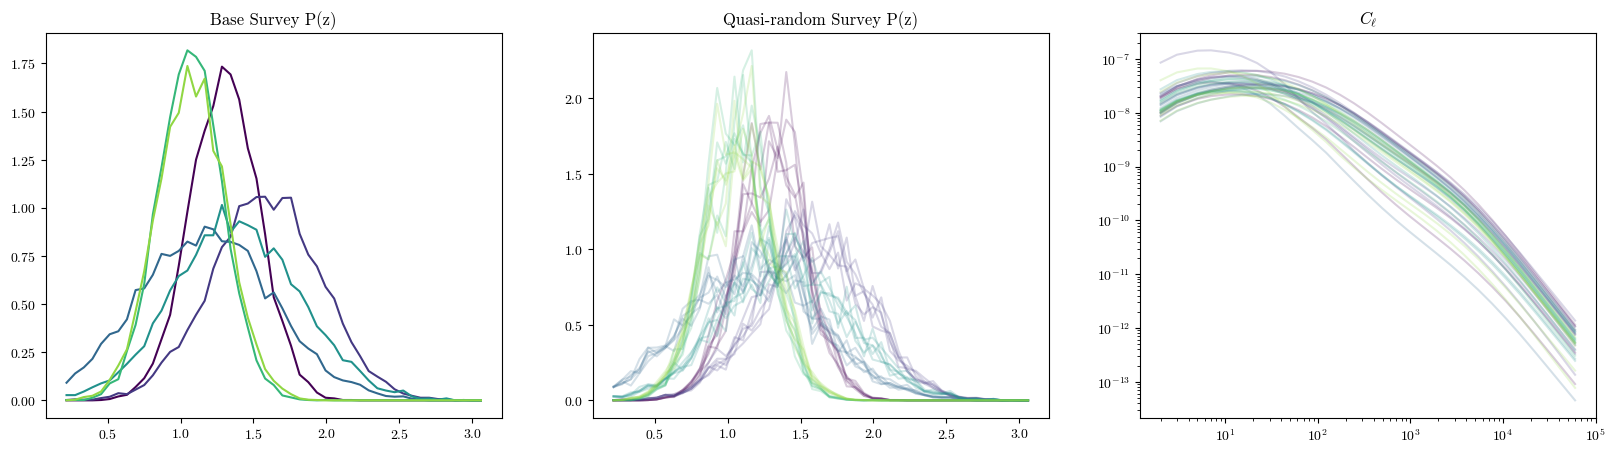

In [6]:
# Plot survey distributions and Cell to see which ones perfrom poorly

fig, ax = plt.subplots(1,3,figsize=(20,5))

for i in range(Y_train.shape[0]):
    if i % 20 == 0:
        color = cmap.to_rgba(i)
        ax[0].plot(survey_midpoints, survey_pz[i], c=color)
        ax[0].set_title('Base Survey P(z)')

        for j in range(Y_train.shape[1]):
            if j % 400 == 0:
                ax[1].plot(survey_midpoints, qrd_pz[i,j], c=color, alpha=0.2)
                ax[1].set_title('Quasi-random Survey P(z)')

                ax[2].loglog(ell_bins, Y_train[i,j,:], c=color, alpha=0.2)
                ax[2].set_title(r'$C_{\ell}$')

Plotting task [110]
Training samples: [ 790 1832 1878 ...  314  128  775]
Test samples: 894


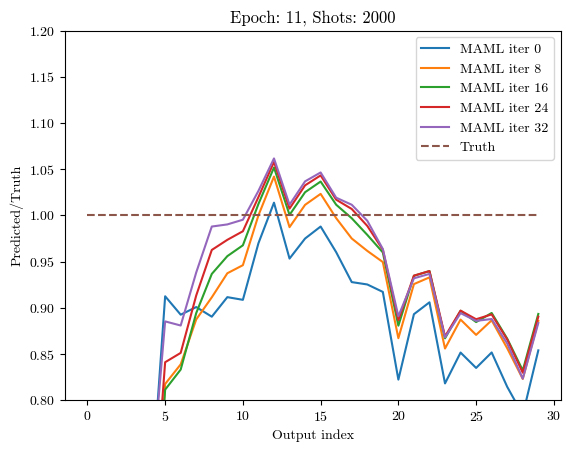

Loss: 0.021577855572104454


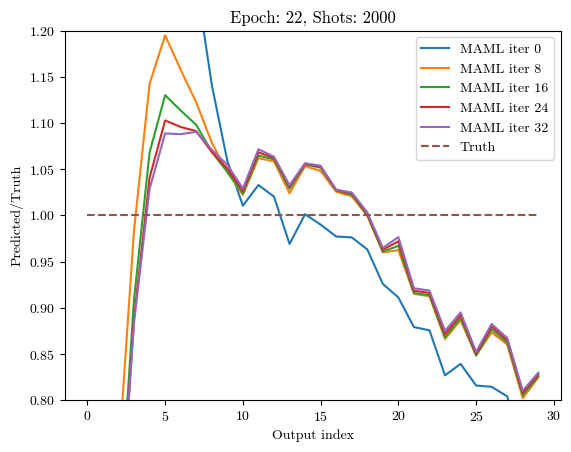

Loss: 0.015027961693704128


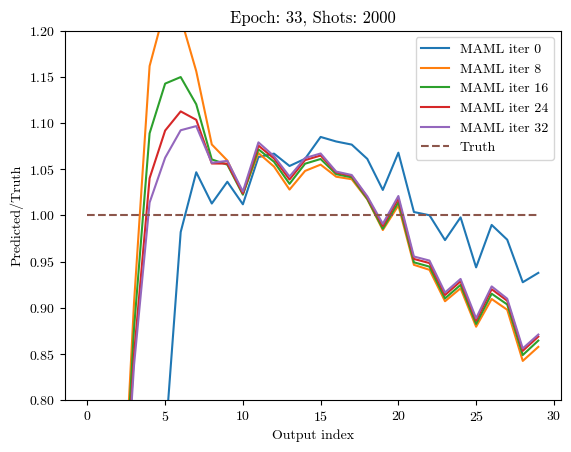

Loss: 0.010065107606351376


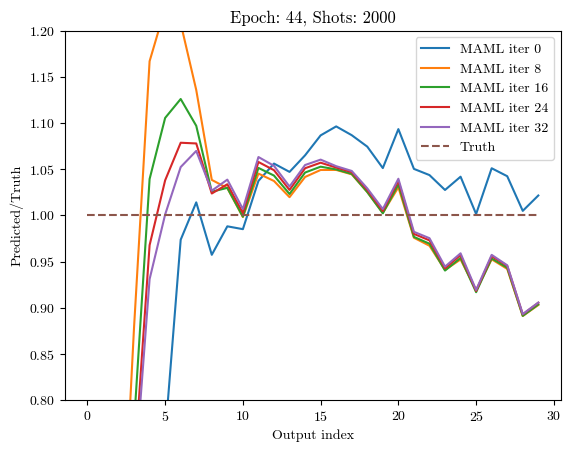

Loss: 0.007471881806850433


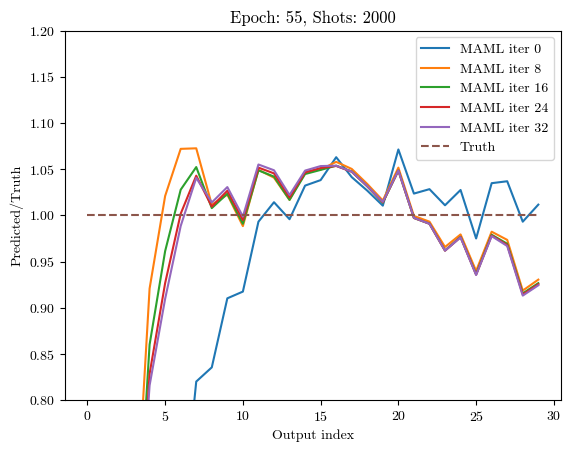

Loss: 0.00762137258425355


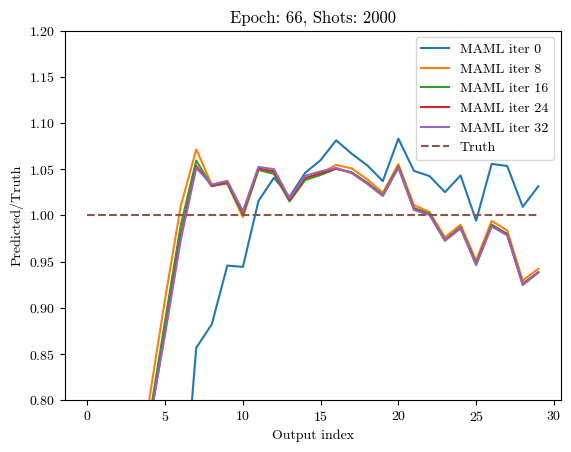

Loss: 0.007281011901795864


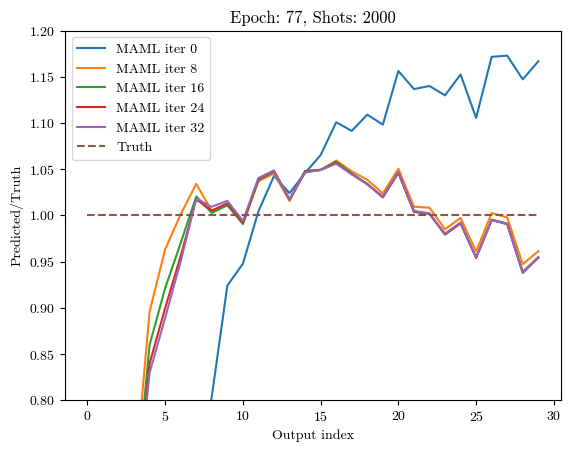

Loss: 0.005076300818473101


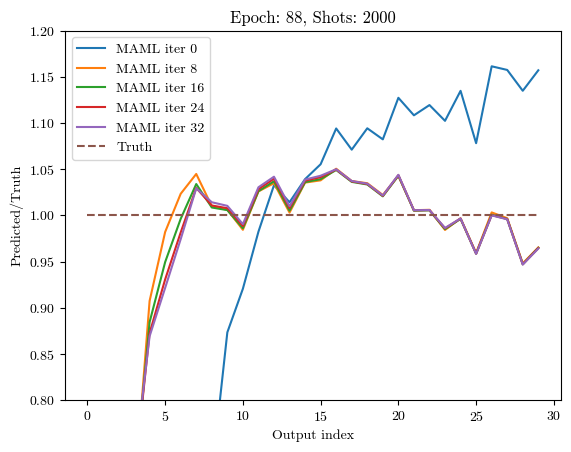

Loss: 0.0038605884183198214


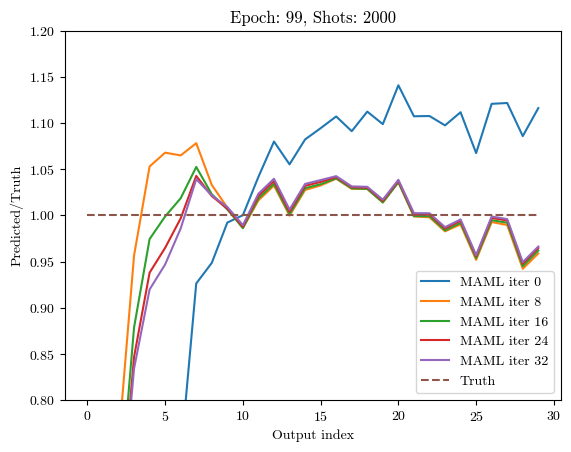

Loss: 0.002442409982904792


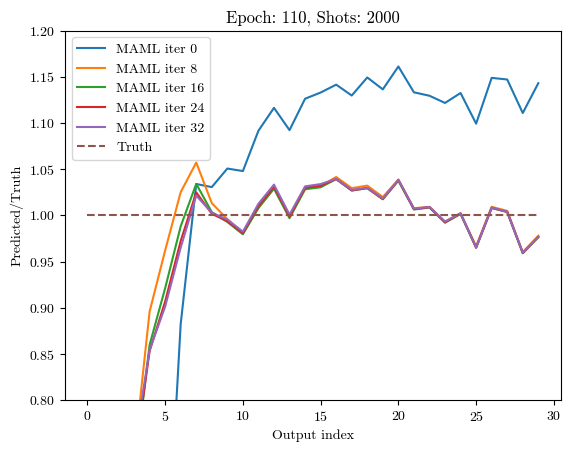

Loss: 0.0030968748033046722


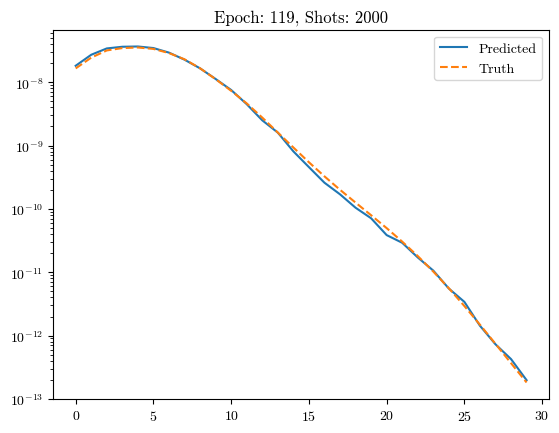

In [48]:
model = models.SimpleMLP(
            in_size=6,
            hidden_size=512,
            out_size=30
        )

# MAML train model
CosyMAML = training.MAML(
            model=model,
            seed=14
        )

loss_MAML = CosyMAML.meta_train(
    x_train=X_train,
    y_train=Y_train,
    inner_lr=0.05,
    outer_lr=0.6,
    inner_decay=1e-3,
    outer_decay=1e-4,
    loss_fn=nn.MSELoss(),
    spt_frac=0.6,
    outer_epochs=1,
    inner_epochs=10,
    plot_prog=True,
    scale=True,
    n_shots=2000
)

In [15]:
ell_bins = np.unique(np.geomspace(2, 60000, 31).astype(int))
ell_bins[6]

22

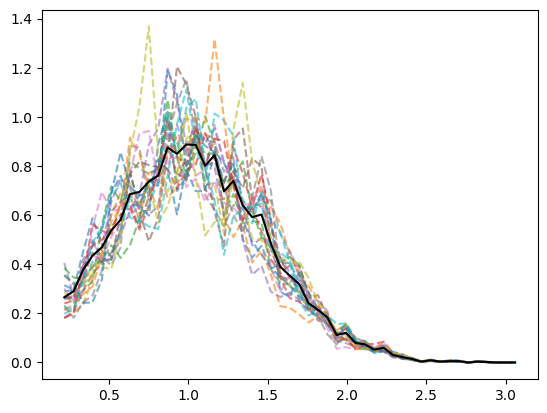

In [6]:
# Now produce a novel test set
novel_pz, novel_midpoints = datamaker.gen_Pz_base(
    0.9,
    0.5,
    gridsize=50
)

n_samples = 2**10
qrd_pz, true_mean = datamaker.gen_Pz_samples(
    novel_pz,
    novel_midpoints,
    seed=24,
    shift=0.02,
    qrd_samples=n_samples
)

plt.figure()
shifts = np.zeros(n_samples)
for i in range(n_samples):
    mean = np.trapz(qrd_pz[i]*novel_midpoints, novel_midpoints)
    shifts[i] = mean - true_mean
    if i % 50 == 0:
        plt.plot(novel_midpoints, qrd_pz[i], alpha=0.6, ls='--')
plt.plot(novel_midpoints, novel_pz, label='True P(z)', c='black')

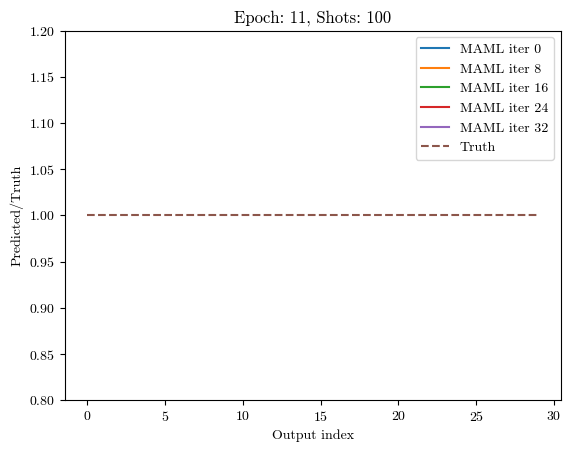

Loss: 1.655746340751648


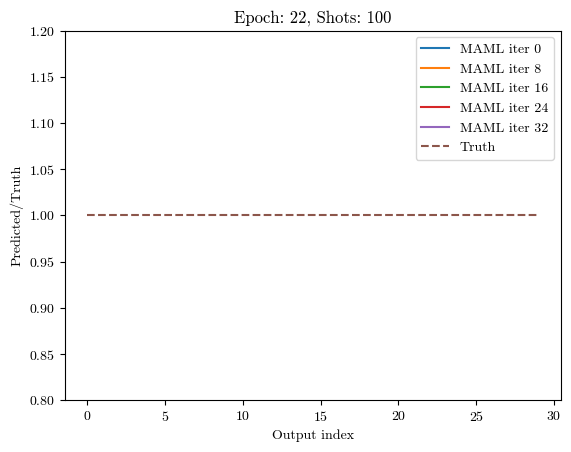

Loss: 1.6234058141708374


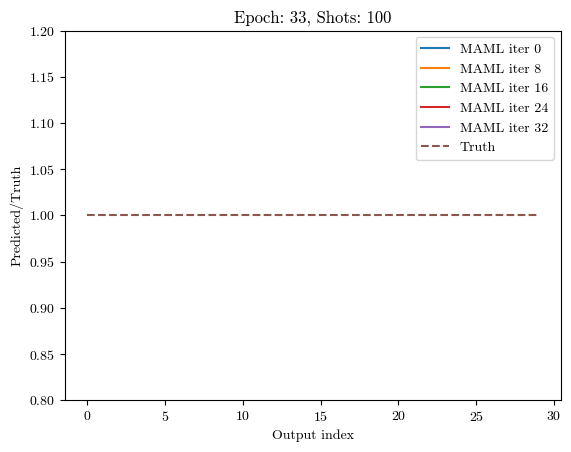

Loss: 1.5998722314834595


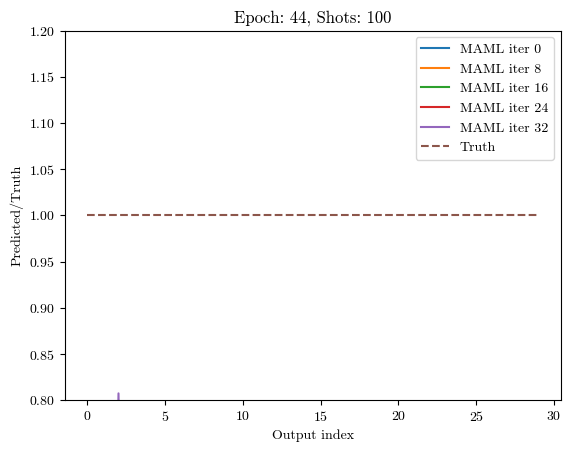

Loss: 1.6360844373703003


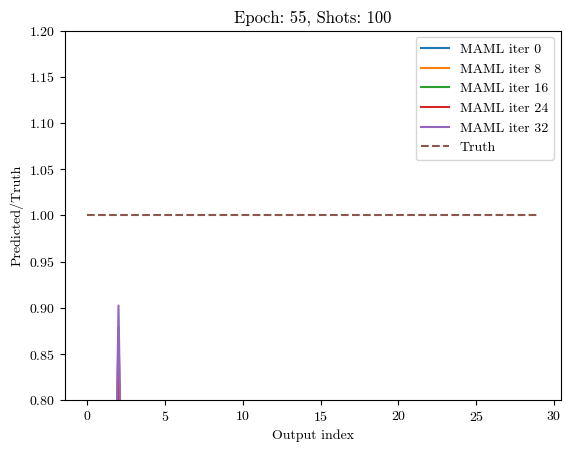

Loss: 1.6281495094299316


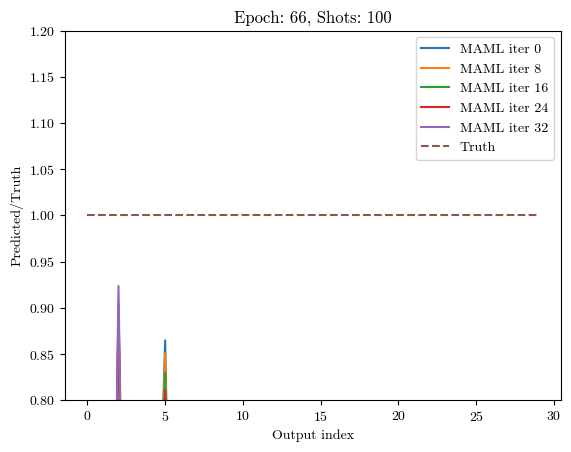

Loss: 1.6278674602508545


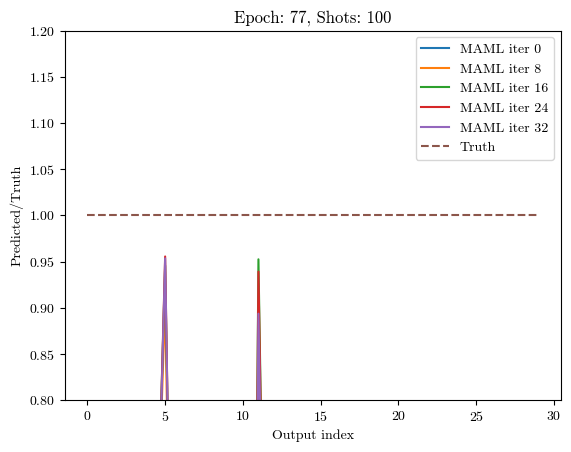

Loss: 1.6243500709533691


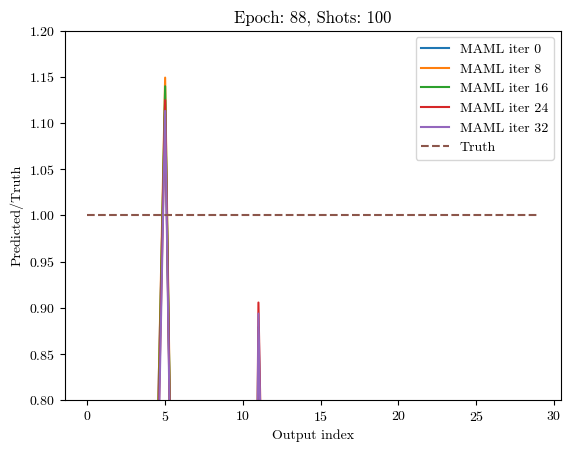

Loss: 1.568922758102417


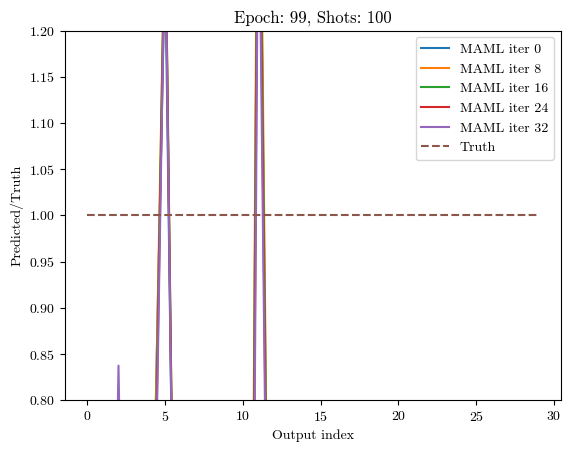

Loss: 1.5747500658035278


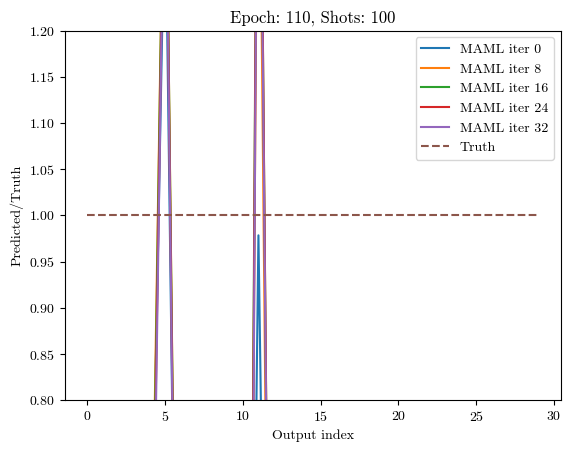

Loss: 1.6097216606140137


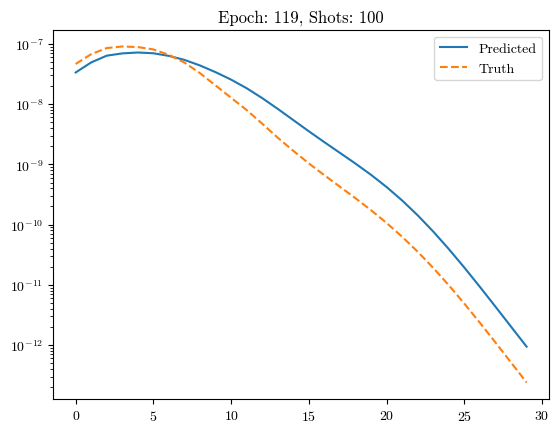

In [52]:
reload(training)

n_out = 30

model = models.SimpleMLP(
            in_size=6,
            hidden_size=512,
            out_size=n_out
        )

# MAML train model
CosyMAML = training.PCA_MAML(
            model=model,
            seed=14,
            pca_components=n_out
        )

loss_MAML = CosyMAML.meta_train(
    x_train=X_train,
    y_train=Y_train,
    inner_lr=0.05,
    outer_lr=0.6,
    inner_decay=1e-3,
    outer_decay=1e-4,
    loss_fn=nn.MSELoss(),
    spt_frac=0.6,
    outer_epochs=1,
    inner_epochs=10,
    plot_prog=True,
    n_shots=100
)